In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset
import sys
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**CIFAR-10** Dataset

In [4]:
transform = T.Compose([ T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])


dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 44772068.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
batchsize   = 256

In [6]:
data_loader = DataLoader(dataset,batch_size=batchsize,shuffle=True,drop_last=True)

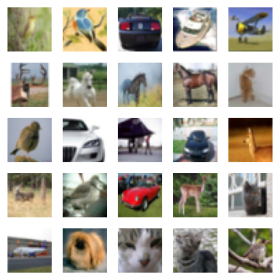

In [7]:
X,y = next(iter(data_loader))
fig,axs = plt.subplots(5,5,figsize=(4,4))
for (i,ax) in enumerate(axs.flatten()):

  
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 
  label = dataset.classes[y[i]]
 
  ax.imshow(pic)
  ax.axis('off')

plt.tight_layout()
plt.show()

# Discriminator Model

In [8]:
class discriminatorNetw(nn.Module):
  def __init__(self):
    super().__init__()

    
    self.conv1 = nn.Conv2d(  3, 64, 4, stride=2, padding=1, bias=False)
    self.conv2 = nn.Conv2d( 64,128, 4, stride=2, padding=1, bias=False)
    self.conv3 = nn.Conv2d(128,256, 4, stride=2, padding=1, bias=False)
    self.conv4 = nn.Conv2d(256,512, 3, stride=1, padding=1, bias=False)
    self.conv5 = nn.Conv2d(512,  1, 4, stride=1, padding=0, bias=False)

    
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)
    
  def forward(self,x):
    x = F.leaky_relu( self.conv1(x) ,.2)
    x = F.leaky_relu( self.conv2(x) ,.2)
    x = self.bn2(x)
    x = F.leaky_relu( self.conv3(x) ,.2)
    x = self.bn3(x)
    x = F.leaky_relu( self.conv4(x) ,.2)
    x = self.bn4(x)
    return torch.sigmoid( self.conv5(x) ).view(-1,1)


disc_net = discriminatorNetw()

# Generator Model

In [9]:
class generatorNetw(nn.Module):
  def __init__(self):
    super().__init__()

    
    self.conv1 = nn.ConvTranspose2d(100,512, 4, stride=1, padding=0, bias=False)
    self.conv2 = nn.ConvTranspose2d(512,256, 4, stride=2, padding=1, bias=False)
    self.conv3 = nn.ConvTranspose2d(256,128, 4, stride=2, padding=1, bias=False)
    self.conv4 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False)
    self.conv5 = nn.ConvTranspose2d(64,   3, 3, stride=1, padding=1, bias=False)

    
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d( 64)


  def forward(self,x):
    x = F.relu( self.bn1(self.conv1(x)) )
    x = F.relu( self.bn2(self.conv2(x)) )
    x = F.relu( self.bn3(self.conv3(x)) )
    x = F.relu( self.bn4(self.conv4(x)) )
    x = torch.tanh( self.conv5(x) )
    return x
    

gen_net = generatorNetw()

Loss Function, Optimizer and DataParallel

In [10]:
lossfun = nn.BCELoss()

disc_net = discriminatorNetw().to(device)
gen_net = generatorNetw().to(device)


if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    disc_net = nn.DataParallel(disc_net)
    gen_net = nn.DataParallel(gen_net)


disc_net.to(device)
gen_net.to(device)

disc_optimizer = torch.optim.Adam(disc_net.parameters(), lr=.0002, betas=(.5, .999))
gen_optimizer = torch.optim.Adam(gen_net.parameters(), lr=.0002, betas=(.5, .999))

Using 2 GPUs!


**Training**

In [11]:
num_epochs = 100
losses  = []
disc_loss = []
genr_loss = []


for epochi in range(num_epochs):
  for data,_ in data_loader:
    
    data = data.to(device)
    
    real_labels = torch.ones(batchsize,1).to(device)
    fake_labels = torch.zeros(batchsize,1).to(device)

    #discriminator part  
    pred_real   = disc_net(data)                     # output 
    d_loss_real = lossfun(pred_real,real_labels) 

    
    fake_data   = torch.randn(batchsize,100,1,1).to(device) 
    fake_images = gen_net(fake_data)                           # output of gen
    pred_fake   = disc_net(fake_images)                         
    d_loss_fake = lossfun(pred_fake,fake_labels)            

    
    d_loss = d_loss_real + d_loss_fake
    
    disc_optimizer.zero_grad()
    d_loss.backward()
    disc_optimizer.step()

    #generator part   
    fake_images = gen_net( torch.randn(batchsize,100,1,1).to(device) )
    pred_fake   = disc_net(fake_images)
  
    g_loss = lossfun(pred_fake,real_labels)
   
    gen_optimizer.zero_grad()
    g_loss.backward()
    gen_optimizer.step()
    
    losses.append([d_loss.item(),g_loss.item()])

    
  print(f'Epoch [{epochi+1}/{num_epochs}], Discriminator Loss: {d_loss.item()}, Generator Loss: {g_loss.item()}')
  disc_loss.append(d_loss.item())
  genr_loss.append(g_loss.item())
  
losses  = np.array(losses)

Epoch [1/100], Discriminator Loss: 0.9723630547523499, Generator Loss: 3.851341724395752
Epoch [2/100], Discriminator Loss: 0.9107255935668945, Generator Loss: 1.9203755855560303
Epoch [3/100], Discriminator Loss: 1.2760648727416992, Generator Loss: 1.4879392385482788
Epoch [4/100], Discriminator Loss: 1.1219630241394043, Generator Loss: 1.5549306869506836
Epoch [5/100], Discriminator Loss: 0.7431954145431519, Generator Loss: 1.754866600036621
Epoch [6/100], Discriminator Loss: 1.0020917654037476, Generator Loss: 1.8458067178726196
Epoch [7/100], Discriminator Loss: 0.8755009770393372, Generator Loss: 1.4059996604919434
Epoch [8/100], Discriminator Loss: 0.8410604596138, Generator Loss: 2.127762794494629
Epoch [9/100], Discriminator Loss: 0.7051746845245361, Generator Loss: 2.0795652866363525
Epoch [10/100], Discriminator Loss: 0.6111346483230591, Generator Loss: 1.8869187831878662
Epoch [11/100], Discriminator Loss: 0.6366351842880249, Generator Loss: 1.7676546573638916
Epoch [12/100]

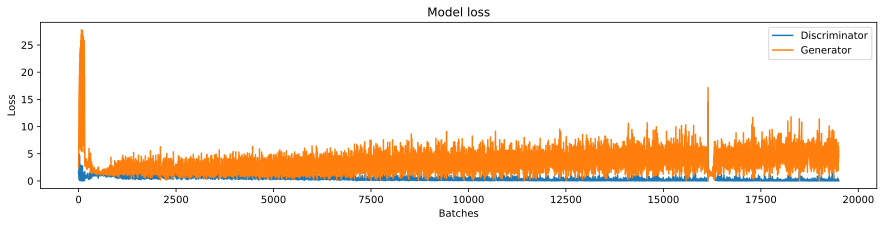

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.plot(losses[:, 0])
plt.plot(losses[:, 1])
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend(['Discriminator', 'Generator'])
plt.show()

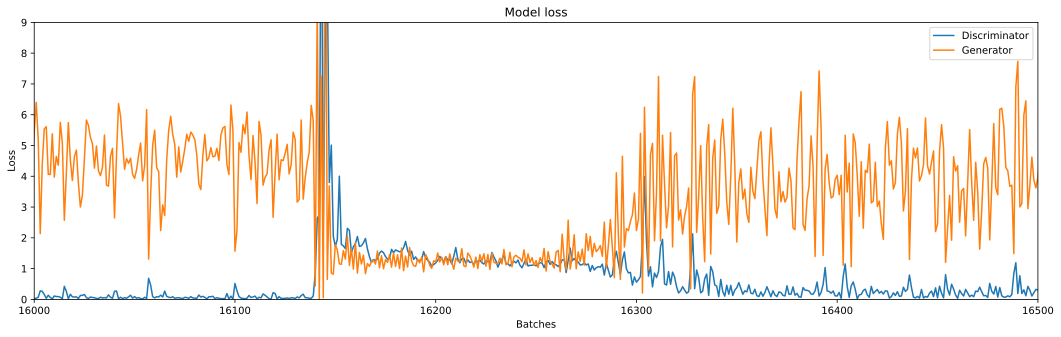

In [26]:
fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(losses[:, 0])
ax.plot(losses[:, 1])
ax.set_xlabel('Batches')
ax.set_ylabel('Loss')
ax.set_title('Model loss')
ax.legend(['Discriminator', 'Generator'])
ax.set_xlim([16000, 16500])
ax.set_ylim([0,9])
plt.show()

Generator images

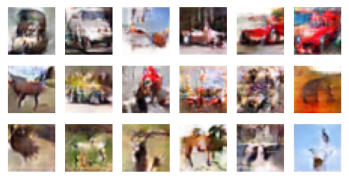

In [14]:
gen_net.eval()
fake_data = gen_net( torch.randn(batchsize,100,1,1).to(device) ).cpu()
fig,axs = plt.subplots(3,6,figsize=(6,3))
for i,ax in enumerate(axs.flatten()):
  pic = fake_data[i,:,].detach().squeeze().numpy().transpose((1,2,0))
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
  ax.imshow(pic) 
  ax.axis('off')
plt.show()

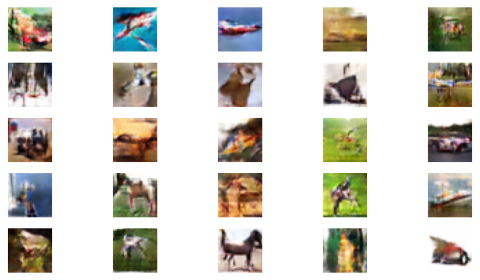

In [20]:
gen_net.eval()
fake_data = gen_net( torch.randn(batchsize,100,1,1).to(device) ).cpu()
fig,axs = plt.subplots(5,5,figsize=(8,4))
for i,ax in enumerate(axs.flatten()):
  pic = fake_data[i,:,].detach().squeeze().numpy().transpose((1,2,0))
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
  ax.imshow(pic)
  ax.axis('off')
plt.savefig('output_images3.png')
plt.tight_layout()
plt.show()